### Objective:

### Cap and Floor Valuation Models

- Implemented pricing of interest rate derivatives (caps and floors) using both Black 76 and Bachelier models.
- Modeled caplets and floorlets as European options on forward rates, incorporating realistic market inputs (term structures, discounting, volatility).
- Conducted sensitivity analysis across strike rates, volatilities, and maturities to compare model behavior and ATM equivalence.


## Implementation

### 1 Pricing Formulas (Quick Recap)

#### 🔹 Black‑76 Caplet/Floorlet

For a caplet/floorlet that **matures at** \( T_1 \), **pays at** \( T_2 \), with:
- Accrual period \( \tau \)
- Forward rate \( F \)
- Discount factor \( P(T_2) \)
- Lognormal volatility \( \sigma_{\ln} \)

The pricing formulas are:

**Caplet:**
$$
\text{Caplet} = \tau \cdot P(T_2) \cdot \left[ F \cdot \Phi(d_1) - K \cdot \Phi(d_2) \right]
$$

**Floorlet:**
$$
\text{Floorlet} = \tau \cdot P(T_2) \cdot \left[ K \cdot \Phi(-d_2) - F \cdot \Phi(-d_1) \right]
$$

Where:
$$
d_{1,2} = \frac{\ln(F/K) \pm \frac{1}{2} \sigma_{\ln}^2 T}{\sigma_{\ln} \sqrt{T}}, \quad T = T_1
$$

---

#### 🔹 Bachelier (Normal) Caplet/Floorlet

Assuming **normal volatility** \( \sigma_n \), the pricing formulas are:

**Caplet:**
$$
\text{Caplet} = \tau \cdot P(T_2) \cdot \left[ (F - K) \cdot \Phi(d) + \sigma_n \sqrt{T} \cdot \phi(d) \right]
$$

**Floorlet:**
$$
\text{Floorlet} = \tau \cdot P(T_2) \cdot \left[ (K - F) \cdot \Phi(-d) + \sigma_n \sqrt{T} \cdot \phi(d) \right]
$$

Where:
$$
d = \frac{F - K}{\sigma_n \sqrt{T}}
$$

---

#### 🔹 ATM Equivalence

When \( K = F \), the models match exactly if:

$$
\sigma_n = F \cdot \sigma_{\ln}
$$

This mapping is useful for comparing cap prices **like-for-like** between Black‑76 and Bachelier models.

   ATMF strike  Cap price Black-76 (100mm)  Cap price Bachelier (100mm)  \
0       0.0352                1.148562e+06                 1.149766e+06   

   Floor price Black-76 (100mm)  Floor price Bachelier (100mm)  
0                  1.168614e+06                   1.169819e+06  
     T1    T2   tau    DF(T2)       Fwd     T  sigma_ln  price_unit_notional  \
0  0.25  0.50  0.25  0.982652  0.035154  0.25  0.188250             0.000319   
1  0.50  0.75  0.25  0.974092  0.035154  0.50  0.177880             0.000424   
2  0.75  1.00  0.25  0.965605  0.035154  0.75  0.168729             0.000489   

    price_100mm  
0  31870.612287  
1  42393.873577  
2  48900.009440  


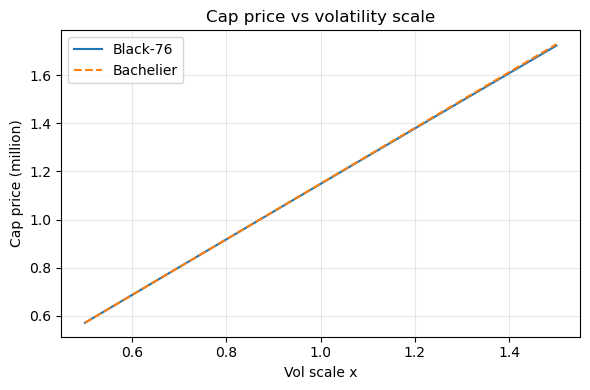

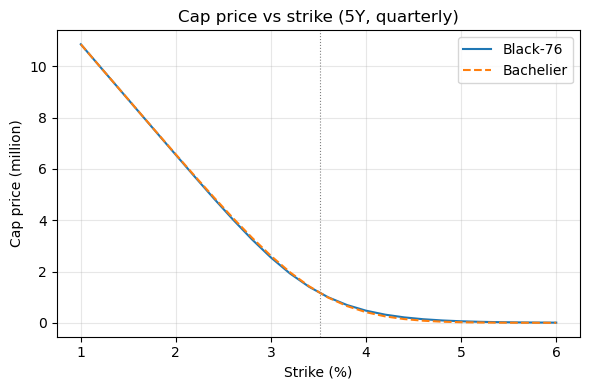

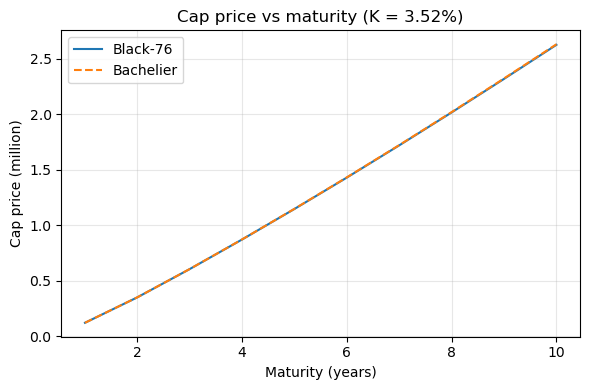

In [4]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1) Market building blocks
# -----------------------------
def discount_factor(T, r=0.035):
    """Flat OIS discount curve with continuously compounded rate r."""
    return math.exp(-r*T)

def forward_rate(T1, T2, r=0.035, daycount=0.25):
    """Simple-compounded forward for [T1,T2] implied by discount curve."""
    P1, P2 = discount_factor(T1, r), discount_factor(T2, r)
    tau = T2 - T1 if daycount is None else daycount
    F = (P1/P2 - 1.0)/tau
    return F, tau, P2

# -----------------------------
# 2) Option pricing models
# -----------------------------
def _phi(x): return 1.0/math.sqrt(2*math.pi)*math.exp(-0.5*x*x)
def _Phi(x): return 0.5*(1+math.erf(x/math.sqrt(2)))

def black76_caplet(F, K, sigma_ln, T, tau, DF_T2, call=True): # sigma_ln = lognormal volatility
    """Caplet/floorlet under Black-76."""
    if sigma_ln <= 0 or T <= 0:
        intrinsic = max(F-K, 0.0) if call else max(K-F, 0.0)
        return DF_T2 * tau * intrinsic
    vol_sqrtT = sigma_ln*math.sqrt(T)
    if F <= 0:  # safeguard for degeneracy
        F = max(F, 1e-12)
    d1 = (math.log(F/K) + 0.5*vol_sqrtT**2) / vol_sqrtT
    d2 = d1 - vol_sqrtT
    if call:
        return DF_T2 * tau * (F*_Phi(d1) - K*_Phi(d2))
    else:
        return DF_T2 * tau * (K*_Phi(-d2) - F*_Phi(-d1))

def bachelier_caplet(F, K, sigma_n, T, tau, DF_T2, call=True): # sigma_n = normal volatility
    """Caplet/floorlet under Bachelier (normal)."""
    if sigma_n <= 0 or T <= 0:
        intrinsic = max(F-K, 0.0) if call else max(K-F, 0.0)
        return DF_T2 * tau * intrinsic
    denom = sigma_n*math.sqrt(T)
    d = (F-K)/denom
    if call:
        return DF_T2 * tau * ((F-K)*_Phi(d) + denom*_phi(d))
    else:
        return DF_T2 * tau * ((K-F)*_Phi(-d) + denom*_phi(d))

# Exact ATM mapping per caplet: σ_n = F * σ_ln
def map_black_to_normal_sigma(F, sigma_ln): # Calculates normal volatility (needed in Bachelier) from lognormal volatility (needed in Black-76)
    return max(F, 0.0) * sigma_ln # This mapping is exact only at ATM, for OTM/ITM it is approximately true. For deep OTM/ITM it is inaccurate

# -----------------------------
# 3) Build caps/floors as portfolios
# -----------------------------
def build_schedule(T_start, T_end, tenor=0.25):
    n = int(round((T_end - T_start)/tenor))
    times = [round(T_start + i*tenor, 10) for i in range(n+1)]
    if times[-1] < T_end - 1e-12:
        times.append(T_end)
    return times

def price_cap_floor(notional, K, T_end, T_start=0.25, tenor=0.25, r=0.035,
                    sigma_ln_fn=None, model='black', cap=True):
    """
    Price a cap/floor as sum of caplets/floorlets.
    sigma_ln_fn(T): Black vol term-structure function of option maturity T.
    For Bachelier we map σ_n=F·σ_ln per caplet (ATM-preserving).
    """
    sched = build_schedule(T_start, T_end, tenor) # will return sched = times
    legs, total = [], 0.0
    for i in range(len(sched)-1):
        T1, T2 = sched[i], sched[i+1]
        F, tau, DF_T2 = forward_rate(T1, T2, r=r, daycount=tenor)
        T = T1  # option expiry from t=0
        sigma_ln = sigma_ln_fn(T) if sigma_ln_fn else 0.2
        if model == 'black':
            price_i = black76_caplet(F, K, sigma_ln, T, tau, DF_T2, call=cap)
        elif model == 'bachelier':
            sigma_n = map_black_to_normal_sigma(F, sigma_ln)
            price_i = bachelier_caplet(F, K, sigma_n, T, tau, DF_T2, call=cap)
        else:
            raise ValueError("model must be 'black' or 'bachelier'")
        legs.append({'T1': T1, 'T2': T2, 'tau': tau, 'DF(T2)': DF_T2, 'Fwd': F,
                     'T': T, 'sigma_ln': sigma_ln, 'price_unit_notional': price_i})
        total += price_i
    return notional*total, pd.DataFrame(legs)

# -----------------------------
# 4) Stylized market inputs
# -----------------------------
# Lognormal vol term structure (10% long-end, ~20% front-end)
def sigma_ln_term(T): 
    return 0.10 + 0.10*math.exp(-T/2.0)

notional = 100_000_000    # 100mm
r_flat   = 0.035          # flat OIS curve
T_start  = 0.25           # first fixing in 3M
tenor    = 0.25           # quarterly
T_end    = 5.0            # 5Y cap/floor

# Compute a par-ish (ATMF) strike as a tau-weighted average forward
sched = build_schedule(T_start, T_end, tenor)
Fwds = []
for i in range(len(sched)-1):
    T1, T2 = sched[i], sched[i+1]
    F, tau, _ = forward_rate(T1, T2, r=r_flat, daycount=tenor)
    Fwds.append((F, tau))
K0 = round(sum(F*tau for F,tau in Fwds)/sum(tau for _,tau in Fwds), 4)

# Prices under both models
cap_black, cap_legs = price_cap_floor(notional, K0, T_end, T_start, tenor, r_flat, sigma_ln_fn=sigma_ln_term, model='black', cap=True)
cap_bach,  _        = price_cap_floor(notional, K0, T_end, T_start, tenor, r_flat, sigma_ln_fn=sigma_ln_term, model='bachelier', cap=True)
floor_black,_       = price_cap_floor(notional, K0, T_end, T_start, tenor, r_flat, sigma_ln_fn=sigma_ln_term, model='black', cap=False)
floor_bach, _       = price_cap_floor(notional, K0, T_end, T_start, tenor, r_flat, sigma_ln_fn=sigma_ln_term, model='bachelier', cap=False)


# -----------------------------
# 6) Plots & CSVs
# -----------------------------
plt.figure(figsize=(6,4))
plt.plot(vol_scales, np.array(cap_black_vs_vol)/1e6, label='Black-76')
plt.plot(vol_scales, np.array(cap_bach_vs_vol)/1e6, label='Bachelier', ls='--')
plt.xlabel('Vol scale x'); plt.ylabel('Cap price (million)')
plt.title('Cap price vs volatility scale'); plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
plt.savefig('cap_vs_vol.png', dpi=160)

plt.figure(figsize=(6,4))
plt.plot(strikes*100, np.array(cap_black_vs_K)/1e6, label='Black-76')
plt.plot(strikes*100, np.array(cap_bach_vs_K)/1e6, label='Bachelier', ls='--')
plt.axvline(K0*100, color='gray', lw=0.8, ls=':')
plt.xlabel('Strike (%)'); plt.ylabel('Cap price (million)')
plt.title('Cap price vs strike (5Y, quarterly)'); plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
plt.savefig('cap_vs_strike.png', dpi=160)

plt.figure(figsize=(6,4))
plt.plot(maturities, np.array(cap_black_vs_T)/1e6, label='Black-76')
plt.plot(maturities, np.array(cap_bach_vs_T)/1e6, label='Bachelier', ls='--')
plt.xlabel('Maturity (years)'); plt.ylabel('Cap price (million)')
plt.title(f'Cap price vs maturity (K = {K0*100:.2f}%)'); plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
plt.savefig('cap_vs_maturity.png', dpi=160)

# Save small CSVs
summary = pd.DataFrame([{
    'ATMF strike': K0,
    'Cap price Black-76 (100mm)': cap_black,
    'Cap price Bachelier (100mm)': cap_bach,
    'Floor price Black-76 (100mm)': floor_black,
    'Floor price Bachelier (100mm)': floor_bach,
}])
summary.to_csv('summary.csv', index=False)

cap_legs_out = cap_legs.head(6).copy()
cap_legs_out['price_100mm'] = cap_legs_out['price_unit_notional']*notional
cap_legs_out.to_csv('cap_legs_sample.csv', index=False)

print(summary)
print(cap_legs_out.head(3))

### Volatility term structure and model comparison

Since we took term structure of volatility (not constant)

Stylized market inputs, the function `sigma_ln_term(T)` is defined as: 0.10 + 0.10*(exp(-T/2))

This means the lognormal volatility depends on the option maturity T, and it decreases with time. Specifically:

- At short maturities (e.g., T ≈ 0), the volatility is close to 20%.
- At long maturities (e.g., T → ∞), the volatility approaches 10%.

So volatility vs maturity is plotted

### Black-76 vs Bachelier Caplet Pricing Near ATM
Secondly, the equivalence of Black76 model and Bachelier model at ATM (F=K) is shown for different maturities as well.

Maturity 1.0Y: Black-76 = 0.00, Bachelier = 0.00
Maturity 3.0Y: Black-76 = 0.00, Bachelier = 0.00
Maturity 5.0Y: Black-76 = 0.00, Bachelier = 0.00


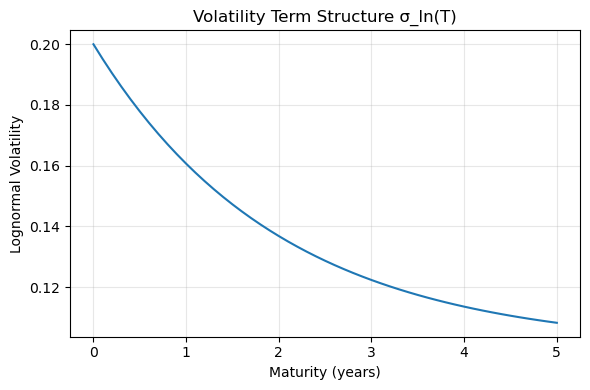

In [1]:
import math
import matplotlib.pyplot as plt

# Volatility term structure function
def sigma_ln_term(T): 
    return 0.10 + 0.10 * math.exp(-T / 2.0)

# Black-76 caplet pricing
def black76_caplet(F, K, sigma_ln, T, tau, DF_T2, call=True):
    if sigma_ln <= 0 or T <= 0:
        intrinsic = max(F-K, 0.0) if call else max(K-F, 0.0)
        return DF_T2 * tau * intrinsic
    vol_sqrtT = sigma_ln * math.sqrt(T)
    F = max(F, 1e-12)
    d1 = (math.log(F/K) + 0.5 * vol_sqrtT**2) / vol_sqrtT
    d2 = d1 - vol_sqrtT
    if call:
        return DF_T2 * tau * (F * 0.5 * (1 + math.erf(d1 / math.sqrt(2))) - K * 0.5 * (1 + math.erf(d2 / math.sqrt(2))))
    else:
        return DF_T2 * tau * (K * 0.5 * (1 - math.erf(d2 / math.sqrt(2))) - F * 0.5 * (1 - math.erf(d1 / math.sqrt(2))))

# Bachelier caplet pricing
def bachelier_caplet(F, K, sigma_n, T, tau, DF_T2, call=True):
    def _phi(x): return 1.0 / math.sqrt(2 * math.pi) * math.exp(-0.5 * x * x)
    def _Phi(x): return 0.5 * (1 + math.erf(x / math.sqrt(2)))
    if sigma_n <= 0 or T <= 0:
        intrinsic = max(F-K, 0.0) if call else max(K-F, 0.0)
        return DF_T2 * tau * intrinsic
    denom = sigma_n * math.sqrt(T)
    d = (F - K) / denom
    if call:
        return DF_T2 * tau * ((F - K) * _Phi(d) + denom * _phi(d))
    else:
        return DF_T2 * tau * ((K - F) * _Phi(-d) + denom * _phi(d))

# Discount factor
def discount_factor(T, r=0.035):
    return math.exp(-r * T)

# Forward rate
def forward_rate(T1, T2, r=0.035, daycount=0.25):
    P1, P2 = discount_factor(T1, r), discount_factor(T2, r)
    tau = T2 - T1 if daycount is None else daycount
    F = (P1 / P2 - 1.0) / tau
    return F, tau, P2

# Plot volatility term structure
maturities = [i * 0.1 for i in range(51)]
vols = [sigma_ln_term(T) for T in maturities]

plt.figure(figsize=(6,4))
plt.plot(maturities, vols)
plt.xlabel('Maturity (years)')
plt.ylabel('Lognormal Volatility')
plt.title('Volatility Term Structure σ_ln(T)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('vol_term_structure.png', dpi=160)

# Compare caplet prices near ATM for T = 1, 3, 5 years
results = []
for T in [1.0, 3.0, 5.0]:
    T1, T2 = T, T + 0.25
    F, tau, DF_T2 = forward_rate(T1, T2)
    K = F  # ATM
    sigma_ln = sigma_ln_term(T)
    sigma_n = F * sigma_ln
    price_black = black76_caplet(F, K, sigma_ln, T, tau, DF_T2)
    price_bach = bachelier_caplet(F, K, sigma_n, T, tau, DF_T2)
    results.append((T, price_black, price_bach))

for T, pb, pn in results:
    print(f"Maturity {T}Y: Black-76 = {pb:.2f}, Bachelier = {pn:.2f}")